In [557]:
# Librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score



### Carga del dataset 

In [558]:
data_path = 'data/HI-Small_Trans.csv'

In [559]:
# Carga de dataset
data = pd.read_csv(data_path)

### Caracterización del dataset
Se realiza una primera inspección sobre el conjunto de datos:

In [560]:
# Mostrapos el tipo de dato del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


Se verifica el número de instancias y columnas del dataset:

In [561]:
# Verificamos las dimensiones del dataset
data.shape

(5078345, 11)

In [562]:
# Verificamos las columnas del dataset
data.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

Se muestran los primeros 5 registros del dataset 

In [563]:
# Mostramos una muestra del dataset
data.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [564]:
# Verificamos la cantidad de registros para el atributo de salida
class_counts = data['Is Laundering'].value_counts()
# Calcula la frecuencia relativa para cada clase
class_percentage = ((class_counts/len(data))*100).round(3)
# Muestra los resultados de frecuencia y frecuencia absoluta
class_summary = pd.DataFrame({  
        "Frencuencia Absoluta":class_counts,
        "Frecuencia Relativa":class_percentage  
        })
class_summary

,Frencuencia Absoluta,Frecuencia Relativa
Is Laundering,,
0,5073168,99.898
1,5177,0.102


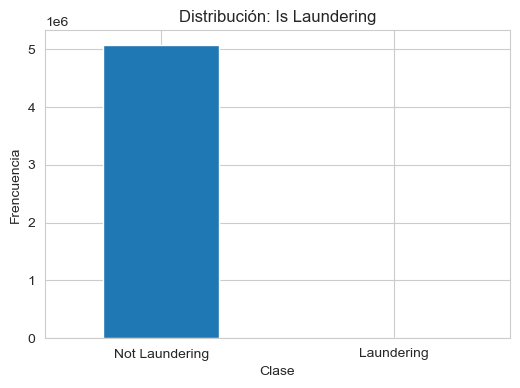

In [565]:
# Visualización de la distribución de la etiqueta Is Laundering
plt.figure(figsize=(6, 4))
data['Is Laundering'].value_counts().plot(kind='bar', )
plt.title('Distribución: Is Laundering')
plt.xlabel('Clase')
plt.ylabel('Frencuencia')
plt.xticks(ticks=[0, 1], labels=['Not Laundering', 'Laundering'], rotation=0)
plt.show()

## Verificación de nulos y nans

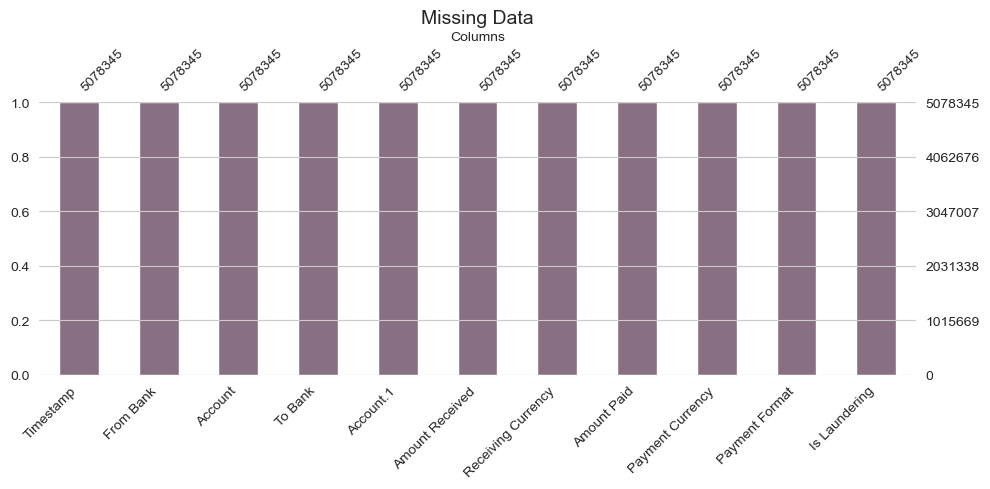

In [566]:
plt.figure(figsize=(10, 4))  # Tamaño ajustado para mejorar la legibilidad
msno.bar(data, sort='ascending', color="#896F82", figsize=(10, 5), fontsize=10)
plt.title('Missing Data', fontsize=14)
plt.xlabel('Columns', fontsize=10)
plt.ylabel('Non-Null Count', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('exports/missing.png', dpi=300)
plt.show()



In [567]:
# Verificamos si el dataset contiene nulos
data.isnull().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

In [568]:
# Verificamos si el dataset contiene nan
data.isna().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

In [569]:
data.duplicated().sum()

9

In [570]:
data.drop_duplicates(inplace=True)

In [571]:
data[['Amount Received', 'Amount Paid']].describe()

,Amount Received,Amount Paid
count,5.078336e+06,5.078336e+06
mean,5.988737e+06,4.509281e+06
std,1.037184e+09,8.697736e+08
min,1.000000e-06,1.000000e-06
25%,1.833700e+02,1.844800e+02
50%,1.411040e+03,1.414570e+03
75%,1.234630e+04,1.229815e+04
max,1.046302e+12,1.046302e+12


In [572]:
# Convertimos la columna Timestamp a formato tipo datetime
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Extraemos fecha, dia y hora
data["Date"] = data["Timestamp"].dt.date
data["Day"] = data["Timestamp"].dt.day_name()
data["Time"] = data["Timestamp"].dt.time                                              

# Removemos columna timestamp
data.drop(columns=["Timestamp"], inplace=True)

In [573]:
# Muestras datos actuales
data.head()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Day,Time
0,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,2022-09-01,Thursday,00:20:00
1,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,2022-09-01,Thursday,00:20:00
2,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,2022-09-01,Thursday,00:00:00
3,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,2022-09-01,Thursday,00:02:00
4,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,2022-09-01,Thursday,00:06:00


### Tipo de unidad monetaria utilizada en casos de lavado de dinero

In [574]:
# Muestra una lista con la unidad monetaria en caso de lavado de dinero para recepción de dinero
receiving = data[data["Is Laundering"] == 1]["Receiving Currency"].value_counts()
receiving

Receiving Currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64

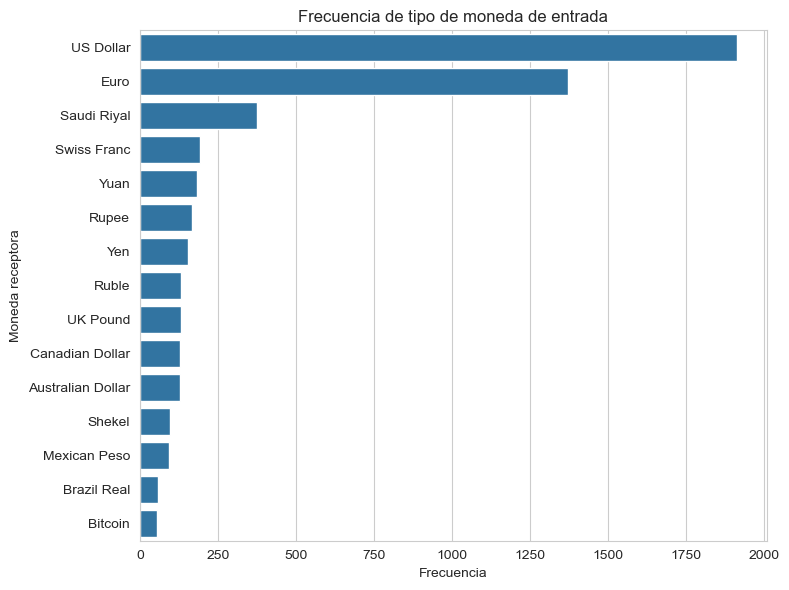

In [575]:
# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.barplot(y=receiving.index, x=receiving.values, orient='h')
plt.title("Frecuencia de tipo de moneda de entrada")
plt.xlabel("Frecuencia")
plt.ylabel("Moneda receptora")
plt.tight_layout()

plt.savefig('exports/receiving_currency.png', dpi=300)
plt.show()

In [576]:
# Crea gráfico de barras para visualizar la unidad monetaria mas frecuente en casos de lavado de dinero para pagos
payment=data[data["Is Laundering"]==1]["Payment Currency"].value_counts()
payment

Payment Currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64

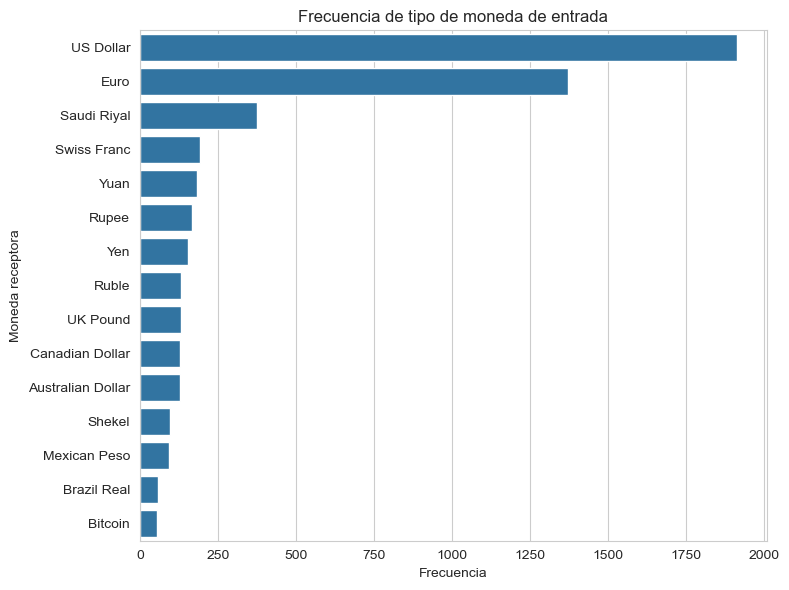

In [577]:
# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.barplot(y=payment.index, x=payment.values, orient='h')
plt.title("Frecuencia de tipo de moneda de entrada")
plt.xlabel("Frecuencia")
plt.ylabel("Moneda receptora")
plt.tight_layout()

plt.savefig('exports/payment_currency.png', dpi=300)
plt.show()

### Formas de pago en casos de lavado de dinero

In [578]:
# Muestra las formas de pago para casos de lavado de dinero
type_trans =  data[data['Is Laundering']==1]['Payment Format'].value_counts()
type_trans

Payment Format
ACH            4483
Cheque          324
Credit Card     206
Cash            108
Bitcoin          56
Name: count, dtype: int64

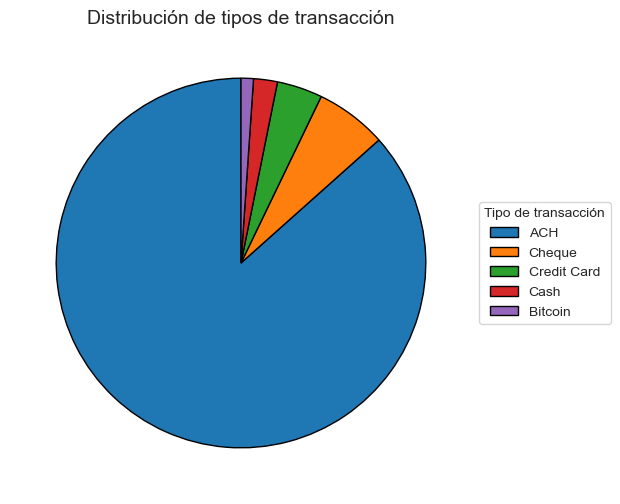

In [600]:
# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.pie(
    type_trans.values, 
    startangle=90, 
    wedgeprops={'edgecolor': 'black'}
)

# Agregar cuadro de leyenda al costado
plt.legend(type_trans.index, title="Tipo de transacción", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Distribución de tipos de transacción", fontsize=14)
plt.savefig('exports/type_trans.png', dpi=300)
plt.show()

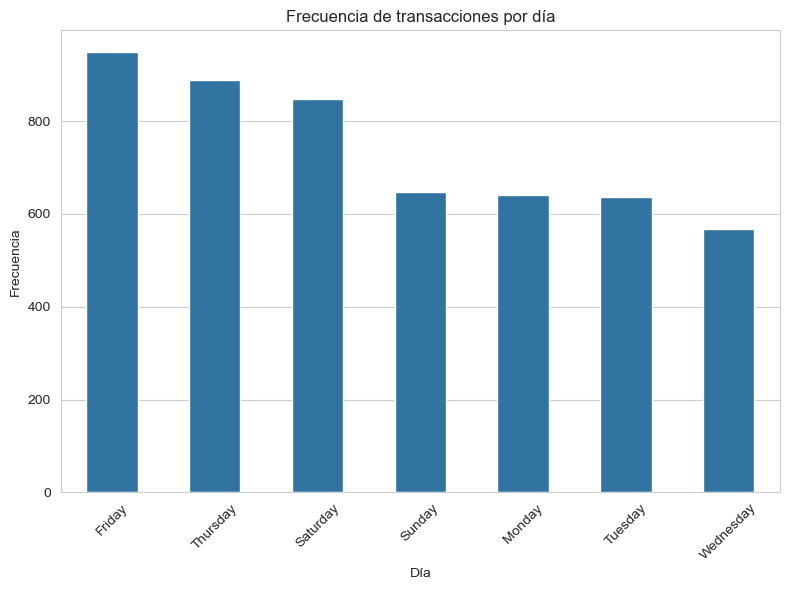

In [601]:
# Crea plot de dias donde existen casos de lavado de dinero
day=data[data["Is Laundering"]==1]["Day"].value_counts()
# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.barplot(x=day.index, y=day.values, width=0.5)
plt.title("Frecuencia de transacciones por día")
plt.xlabel("Día")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)  # Ajustar rotación de etiquetas si es necesario
plt.tight_layout()

plt.savefig('exports/day_trans.png', dpi=300)
plt.show()

In [581]:
# Muestra la frecuencia de casos de lavado de dinero por dia
day

Day
Friday       948
Thursday     889
Saturday     848
Sunday       647
Monday       641
Tuesday      637
Wednesday    567
Name: count, dtype: int64

### Manejo de desbalance de datos

In [582]:
data['Is Laundering'].value_counts()

Is Laundering
0    5073159
1       5177
Name: count, dtype: int64

In [583]:
X = data.drop(['Is Laundering'],axis = 1)
y = data['Is Laundering']

In [584]:
over = RandomOverSampler(sampling_strategy=0.1)
X,y = over.fit_resample(X,y)

In [585]:
Counter(y)

Counter({0: 5073159, 1: 507315})

In [586]:
under = RandomUnderSampler(sampling_strategy=0.6)
X, y = under.fit_resample(X,y)

In [587]:
Counter(y)

Counter({0: 845525, 1: 507315})

/var/folders/wm/92j7hzb14f31hd_83526jfh40000gn/T/ipykernel_87370/3887819392.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sampled_data.index, y=sampled_data.values,width=0.5, palette=['#133E87', '#CC2B52'] )


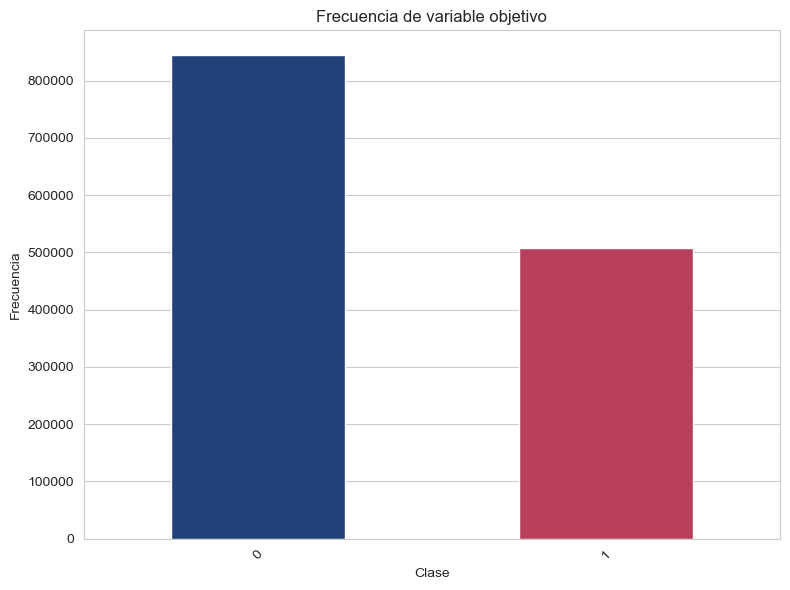

In [588]:
sampled_data = y.value_counts()

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.barplot(x=sampled_data.index, y=sampled_data.values,width=0.5, palette=['#133E87', '#CC2B52'] )
plt.title("Frecuencia de variable objetivo")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)  # Ajustar rotación de etiquetas si es necesario
plt.tight_layout()

plt.savefig('exports/sampled_data.png', dpi=300)
plt.show()

### Creacion de conjuntos de datos

In [589]:
# Combinar X, y en un solo dataframe
data_balanced = pd.concat([X, y], axis=1)

# Divide el conjunto de datos completo en 2 partes
part1, part2 = train_test_split(data_balanced, test_size=0.5, stratify= data_balanced['Is Laundering'], random_state=42)
# Divide cada partición nuevamente en 2 partes
split1, split2 = train_test_split(part1, test_size=0.5, stratify=part1['Is Laundering'], random_state=42)
split3, split4 = train_test_split(part2, test_size=0.5, stratify=part2['Is Laundering'], random_state=42)


In [590]:
data_balanced.shape

(1352840, 13)

In [591]:
split1.shape, split2.shape, split2.shape, split4.shape

((338210, 13), (338210, 13), (338210, 13), (338210, 13))

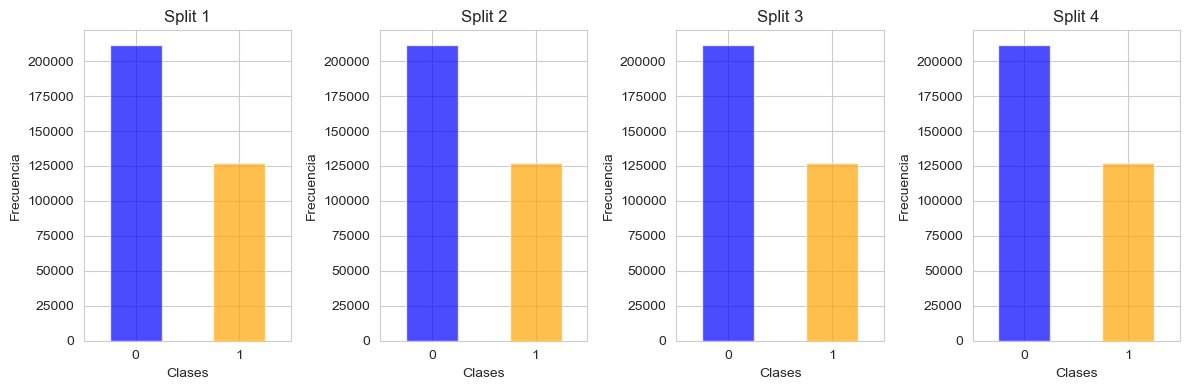

In [595]:
# Crear un gráfico de barras para mostrar la distribución de clases en cada subconjunto
splits = [split1, split2, split3, split4]
titles = ["Split 1", "Split 2", "Split 3", "Split 4"]

plt.figure(figsize=(12, 4))
for i, split in enumerate(splits):
    plt.subplot(1, 4, i + 1)
    split['Is Laundering'].value_counts().plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
    plt.title(f"{titles[i]}")
    plt.xlabel("Clases")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=0)

plt.tight_layout()

plt.savefig('exports/partitions.png', dpi=300)
plt.show()

In [433]:
# Exporta los datos transformados en ficheros separados
split1.to_csv('database/data1.csv', index=False)
split2.to_csv('database/data2.csv', index=False)
split3.to_csv('database/data3.csv', index=False)
split4.to_csv('database/data4.csv', index=False)

### Implementación de XGBoost

In [434]:
data = pd.read_csv('database/data3.csv')

# Define input features (X) and target variable (y)
input_columns = ['From Bank','To Bank','Amount Received','Amount Paid']
X = data[input_columns]
y = data['Is Laundering']


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [340]:
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

model = XGBClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 8, 'subsample': 0.7}
Best AUC Score: 0.9478643289838873


In [374]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'lambda': trial.suggest_loguniform('lambda', 1e-4, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 10.0)
    }
    
    model = XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)

[I 2024-12-01 13:17:43,515] A new study created in memory with name: no-name-f9d8e12e-f2ea-46c0-9291-3951a05f493b
/var/folders/wm/92j7hzb14f31hd_83526jfh40000gn/T/ipykernel_87370/4000134979.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
/var/folders/wm/92j7hzb14f31hd_83526jfh40000gn/T/ipykernel_87370/4000134979.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/wm/92j7hzb14f31hd_83526jfh40000gn/T/ipykernel_87370/4000134979.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

Best Parameters: {'max_depth': 11, 'learning_rate': 0.1564960673045264, 'n_estimators': 680, 'subsample': 0.6690385782792252, 'colsample_bytree': 0.9564455562076204, 'gamma': 0.005872499061300496, 'min_child_weight': 9, 'lambda': 0.012542997268376503, 'alpha': 2.837834277207051}
